# Government Scoring

## Getting Started

### Loading Countries + Regions

In [18]:
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Fetch all countries from the World Bank API and create a DataFrame in one step
countries_data = wbdata.get_countries()
#convert into a dataframe
country_df = pd.DataFrame([{
    'CountryID': country['id'],
    'Region Name': country['region']['value'],
    'Country Name': country['name'],
    'Country Region ID': country['region']['id'],
    'Adminergion ID': country['adminregion']['id'],
    'Income Level': country['incomeLevel']['value'],
    'Lending Type': country['lendingType']['value']}
    for country in countries_data if country['region']['value'] != "Aggregates"
])
country_df

,CountryID,Region Name,Country Name,Country Region ID,Adminergion ID,Income Level,Lending Type
0,ABW,Latin America & Caribbean,Aruba,LCN,,High income,Not classified
1,AFG,South Asia,Afghanistan,SAS,SAS,Low income,IDA
2,AGO,Sub-Saharan Africa,Angola,SSF,SSA,Lower middle income,IBRD
3,ALB,Europe & Central Asia,Albania,ECS,ECA,Upper middle income,IBRD
4,AND,Europe & Central Asia,Andorra,ECS,,High income,Not classified
...,...,...,...,...,...,...,...
212,XKX,Europe & Central Asia,Kosovo,ECS,ECA,Upper middle income,IDA
213,YEM,Middle East & North Africa,"Yemen, Rep.",MEA,MNA,Low income,IDA
214,ZAF,Sub-Saharan Africa,South Africa,SSF,SSA,Upper middle income,IBRD
215,ZMB,Sub-Saharan Africa,Zambia,SSF,SSA,Lower middle income,IDA


### Loading List of Topics

In [19]:
#Preditermined list of topics via distinct 90% Confidence interval metric in title
topics_df=pd.DataFrame(pd.json_normalize(wbdata.get_indicators(query="90% Confidence Interval")))
topics_df=topics_df[['id','name','sourceNote','sourceOrganization']]
topics_df

,id,name,sourceNote,sourceOrganization
0,CC.PER.RNK.LOWER,"Control of Corruption: Percentile Rank, Lower ...",Control of Corruption captures perceptions of ...,"Detailed documentation of the WGI, interactive..."
1,CC.PER.RNK.UPPER,"Control of Corruption: Percentile Rank, Upper ...",Control of Corruption captures perceptions of ...,"Detailed documentation of the WGI, interactive..."
2,GE.PER.RNK.LOWER,"Government Effectiveness: Percentile Rank, Low...",Government Effectiveness captures perceptions ...,"Detailed documentation of the WGI, interactive..."
3,GE.PER.RNK.UPPER,"Government Effectiveness: Percentile Rank, Upp...",Government Effectiveness captures perceptions ...,"Detailed documentation of the WGI, interactive..."
4,PV.PER.RNK.LOWER,Political Stability and Absence of Violence/Te...,Political Stability and Absence of Violence/Te...,"Detailed documentation of the WGI, interactive..."
5,PV.PER.RNK.UPPER,Political Stability and Absence of Violence/Te...,Political Stability and Absence of Violence/Te...,"Detailed documentation of the WGI, interactive..."
6,RL.PER.RNK.LOWER,"Rule of Law: Percentile Rank, Lower Bound of 9...",Rule of Law captures perceptions of the extent...,"Detailed documentation of the WGI, interactive..."
7,RL.PER.RNK.UPPER,"Rule of Law: Percentile Rank, Upper Bound of 9...",Rule of Law captures perceptions of the extent...,"Detailed documentation of the WGI, interactive..."
8,RQ.PER.RNK.LOWER,"Regulatory Quality: Percentile Rank, Lower Bou...",Regulatory Quality captures perceptions of the...,"Detailed documentation of the WGI, interactive..."
9,RQ.PER.RNK.UPPER,"Regulatory Quality: Percentile Rank, Upper Bou...",Regulatory Quality captures perceptions of the...,"Detailed documentation of the WGI, interactive..."


## Data Exploration

### Control of Corruption

In [20]:
specific_topics=topics_df[topics_df['id'].isin(['CC.PER.RNK.LOWER','CC.PER.RNK.UPPER'])]
print(f"Description:\n\t{specific_topics['sourceNote'].iloc[0]}\n\nSource Organization:\n\t{specific_topics['sourceOrganization'].iloc[0]}")

Description:
	Control of Corruption captures perceptions of the extent to which public power is exercised for private gain, including both petty and grand forms of corruption, as well as "capture" of the state by elites and private interests.  Percentile rank indicates the country's rank among all countries covered by the aggregate indicator, with 0 corresponding to lowest rank, and 100 to highest rank.  Percentile ranks have been adjusted to correct for changes over time in the composition of the countries covered by the WGI.  Percentile Rank Lower refers to lower bound of 90 percent confidence interval for governance, expressed in percentile rank terms.

Source Organization:
	Detailed documentation of the WGI, interactive tools for exploring the data, and full access to the underlying source data available at www.govindicators.org. The WGI are produced by Daniel Kaufmann (Natural Resource Governance Institute and Brookings Institution) and Aart Kraay (World Bank Development Research 

#### Loading the Data

In [56]:
# Fetch series data and transform into DataFrame
temp_series = wbdata.get_series(indicator='CC.PER.RNK.LOWER', parse_dates=True)
temp_df_1 = temp_series.reset_index().dropna()
temp_df_1.columns = ['Country/Region', 'Date', 'Lower Bound']
# Fetch series data and transform into DataFrame
temp_series = wbdata.get_series(indicator='CC.PER.RNK.UPPER', parse_dates=True)
temp_df_2 = temp_series.reset_index().dropna()
temp_df_2.columns = ['Country/Region', 'Date', 'Upper Bound']

#Combine
full_df = pd.merge(temp_df_1, temp_df_2, on=['Country/Region', 'Date'])
full_df['Range'] = full_df['Upper Bound'] - full_df['Lower Bound']
full_df['Middle Value']= (full_df['Upper Bound'] + full_df['Lower Bound'])/2
full_df['Relative Range Value']= full_df['Range']/full_df['Middle Value']

#MERGED DF
#Keep only the most recent date for each country
most_recent_df = full_df.loc[full_df.groupby('Country/Region')['Date'].idxmax()]

# Merge with country data
merged_df = pd.merge(most_recent_df, country_df, left_on='Country/Region', right_on='Country Name')

# Display the final dataframe
merged_df.reset_index(drop=True, inplace=True)
#FULL MERGED DF
# Merge with country data
full_merged_df = pd.merge(full_df, country_df, left_on='Country/Region', right_on='Country Name')
# Display the final dataframe
full_merged_df.reset_index(drop=True, inplace=True)

#### Visualizations

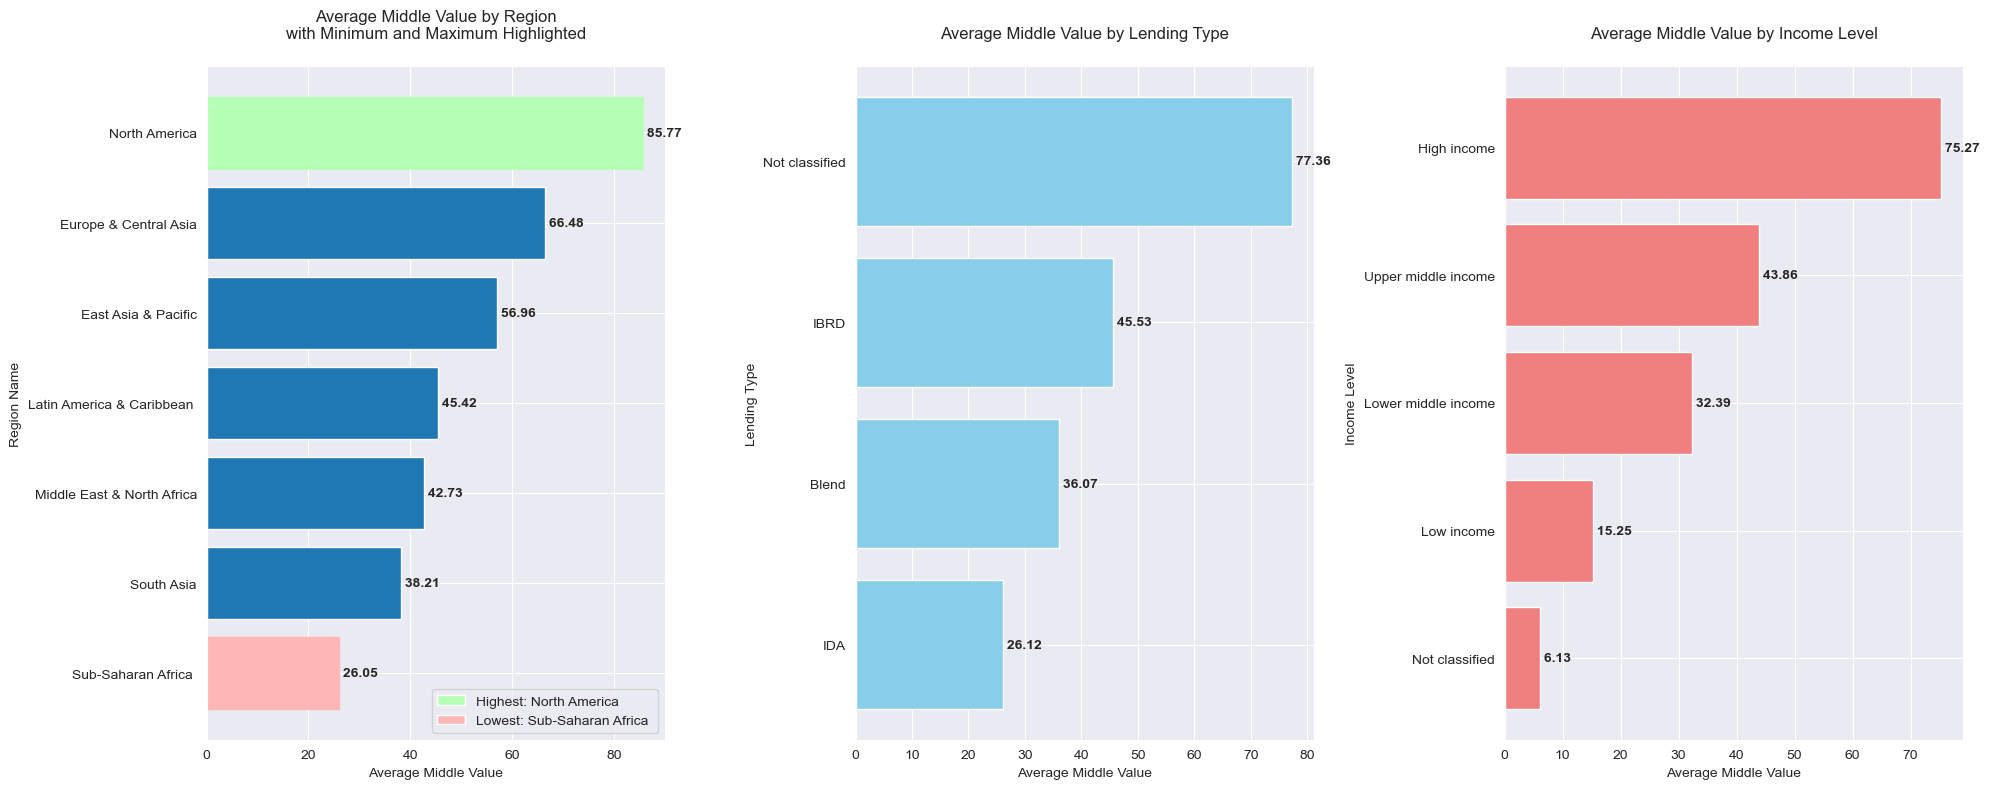

In [52]:
# Calculate statistics for Lending Type
lending_stats = merged_df.groupby('Lending Type')['Middle Value'].mean().sort_values()

# Calculate statistics for Income Level
income_stats = merged_df.groupby('Income Level')['Middle Value'].mean().sort_values()

# Create a figure for subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 1, 1]})

# Bar plot for Regional Statistics
region_bars = axes[0].barh(region_stats.index, region_stats['mean'])
axes[0].set_title('Average Middle Value by Region\nwith Minimum and Maximum Highlighted', pad=20)
axes[0].set_xlabel('Average Middle Value')
axes[0].set_ylabel('Region Name')

# Add value labels on the bars for regions
for i, bar in enumerate(region_bars):
    axes[0].text(bar.get_width(), i, f' {bar.get_width():.2f}', va='center', fontweight='bold')

# Highlight min/max regions
region_bars[0].set_color(min_color)  # Lowest
region_bars[-1].set_color(max_color)  # Highest

# Add legend for min/max
legend_elements = [
    Patch(facecolor=max_color, label=f'Highest: {region_stats.index[-1]}'),
    Patch(facecolor=min_color, label=f'Lowest: {region_stats.index[0]}')
]
axes[0].legend(handles=legend_elements, loc='lower right')

# Bar plot for Lending Type Statistics
axes[1].barh(lending_stats.index, lending_stats, color='skyblue')
axes[1].set_title('Average Middle Value by Lending Type', pad=20)
axes[1].set_xlabel('Average Middle Value')
axes[1].set_ylabel('Lending Type')

# Add value labels on the bars for Lending Type
for i, value in enumerate(lending_stats):
    axes[1].text(value, i, f' {value:.2f}', va='center', fontweight='bold')

# Bar plot for Income Level Statistics
axes[2].barh(income_stats.index, income_stats, color='lightcoral')
axes[2].set_title('Average Middle Value by Income Level', pad=20)
axes[2].set_xlabel('Average Middle Value')
axes[2].set_ylabel('Income Level')

# Add value labels on the bars for Income Level
for i, value in enumerate(income_stats):
    axes[2].text(value, i, f' {value:.2f}', va='center', fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()


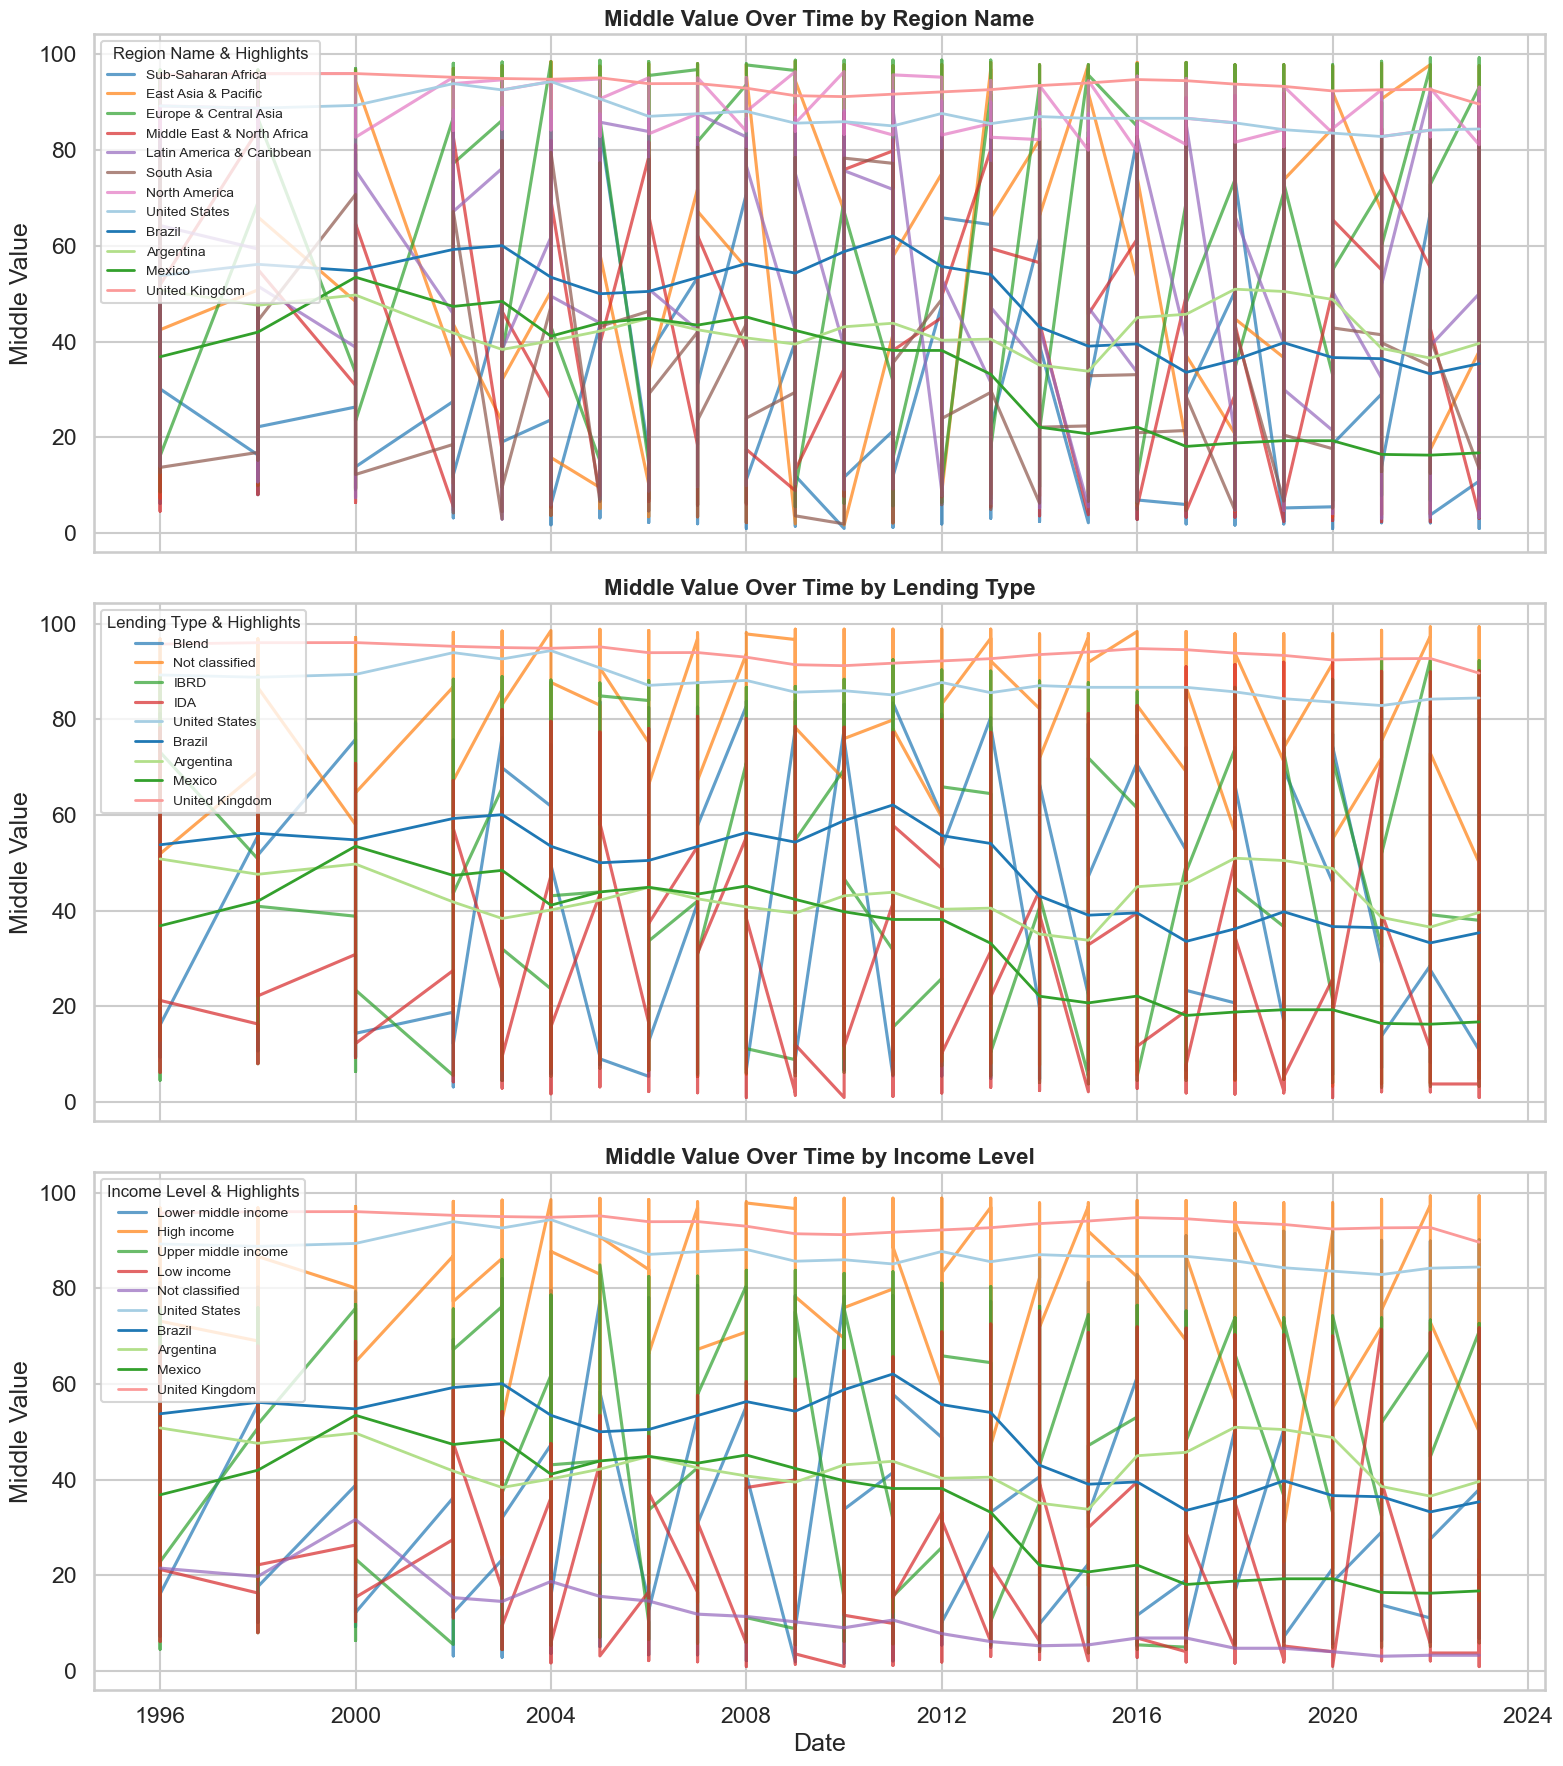

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set seaborn style and context
sns.set_style('whitegrid')
sns.set_context('talk')

# Ensure the dataframe is sorted for proper time series plotting
full_merged_df['Date'] = pd.to_datetime(full_merged_df['Date'])
time_series_df = full_merged_df.sort_values(by='Date')

# Initialize subplot grid
fig, axes = plt.subplots(3, 1, figsize=(16, 18), sharex=True)

# Colors for individual countries
palette_countries = sns.color_palette('Paired', n_colors=len(time_series_df['Country Name'].unique()))

# Define specific countries to highlight
countries_to_highlight = ['United States', 'Brazil', 'Argentina', 'Mexico', 'United Kingdom']

# Region Name Plot
for region in time_series_df['Region Name'].unique():
    region_data = time_series_df[time_series_df['Region Name'] == region]
    axes[0].plot(
        region_data['Date'],
        region_data['Middle Value'],
        label=region,
        alpha=0.7
    )

# Highlight specific countries
for country, color in zip(countries_to_highlight, palette_countries):
    country_data = time_series_df[time_series_df['Country Name'] == country]
    if not country_data.empty:
        axes[0].plot(
            country_data['Date'],
            country_data['Middle Value'],
            label=country,
            color=color,
            linewidth=2
        )

axes[0].set_title('Middle Value Over Time by Region Name', fontweight='bold', fontsize=16)
axes[0].set_ylabel('Middle Value')
axes[0].legend(title='Region Name & Highlights', fontsize=10, title_fontsize=12, loc='upper left', frameon=True)

# Lending Type Plot
for lending in time_series_df['Lending Type'].unique():
    lending_data = time_series_df[time_series_df['Lending Type'] == lending]
    axes[1].plot(
        lending_data['Date'],
        lending_data['Middle Value'],
        label=lending,
        alpha=0.7
    )

# Highlight specific countries
for country, color in zip(countries_to_highlight, palette_countries):
    country_data = time_series_df[time_series_df['Country Name'] == country]
    if not country_data.empty:
        axes[1].plot(
            country_data['Date'],
            country_data['Middle Value'],
            label=country,
            color=color,
            linewidth=2
        )

axes[1].set_title('Middle Value Over Time by Lending Type', fontweight='bold', fontsize=16)
axes[1].set_ylabel('Middle Value')
axes[1].legend(title='Lending Type & Highlights', fontsize=10, title_fontsize=12, loc='upper left', frameon=True)

# Income Level Plot
for income in time_series_df['Income Level'].unique():
    income_data = time_series_df[time_series_df['Income Level'] == income]
    axes[2].plot(
        income_data['Date'],
        income_data['Middle Value'],
        label=income,
        alpha=0.7
    )

# Highlight specific countries
for country, color in zip(countries_to_highlight, palette_countries):
    country_data = time_series_df[time_series_df['Country Name'] == country]
    if not country_data.empty:
        axes[2].plot(
            country_data['Date'],
            country_data['Middle Value'],
            label=country,
            color=color,
            linewidth=2
        )

axes[2].set_title('Middle Value Over Time by Income Level', fontweight='bold', fontsize=16)
axes[2].set_ylabel('Middle Value')
axes[2].set_xlabel('Date')
axes[2].legend(title='Income Level & Highlights', fontsize=10, title_fontsize=12, loc='upper left', frameon=True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from requests.exceptions import ConnectionError
from scipy.stats import ttest_rel

sns.set_style('whitegrid')
sns.set_context('talk')


def safe_get_data(indicator, countries, attempts=3, delay=5):
    """
    Safely fetch data from the World Bank API with retries.
    If a ConnectionError occurs, waits `delay` seconds and retries up to `attempts` times.
    """
    for i in range(attempts):
        try:
            data = wbdata.get_data(indicator, country=countries)
            return data
        except ConnectionError:
            print(
                f"Connection error for indicator {indicator}, attempt {i + 1}/{attempts}. Retrying in {delay} seconds...")
            time.sleep(delay)
    print(f"Failed to fetch {indicator} after {attempts} attempts.")
    return []


def process_data(male_data, female_data):
    """
    Process data for male and female indicators, ensuring alignment by date.
    """
    df_m = pd.DataFrame(male_data)
    df_f = pd.DataFrame(female_data)

    df_m['date'] = pd.to_numeric(df_m['date'], errors='coerce')
    df_f['date'] = pd.to_numeric(df_f['date'], errors='coerce')
    df_m = df_m[['date', 'value']].dropna()
    df_f = df_f[['date', 'value']].dropna()

    common_years = set(df_m['date']).intersection(set(df_f['date']))
    if not common_years:
        return None, None

    df_m = df_m[df_m['date'].isin(common_years)].set_index('date').sort_index()
    df_f = df_f[df_f['date'].isin(common_years)].set_index('date').sort_index()

    return df_m['value'], df_f['value']


def plot_indicators(pairs, entities, entity_color_map):
    """
    Plot indicators for male, female, and their differences for multiple entities.
    """
    fig, axes = plt.subplots(len(pairs), 2, figsize=(20, 4 * len(pairs)))
    if len(pairs) == 1:
        axes = [axes]  # Ensure iterable if only one pair
    fig.suptitle("Male vs. Female Indicators: All Entities Overlaid", fontsize=16, fontweight='bold', y=1.02)

    for i, (male_indicator, female_indicator, title) in enumerate(pairs):
        ax_line, ax_diff = axes[i]

        for entity_code, entity_name in entities:
            male_data = safe_get_data(male_indicator, entity_code)
            female_data = safe_get_data(female_indicator, entity_code)

            male_values, female_values = process_data(male_data, female_data)
            if male_values is None or female_values is None:
                continue

            pvalue = ttest_rel(male_values, female_values, nan_policy='omit')[1] if len(male_values) >= 2 else None
            color = entity_color_map[entity_name]

            ax_line.plot(male_values.index, male_values, label=f'{entity_name} Male', color=color, marker='o',
                         linestyle='-')
            ax_line.plot(female_values.index, female_values, label=f'{entity_name} Female', color=color, marker='^',
                         linestyle='--')

            difference = male_values - female_values
            ax_diff.plot(difference.index, difference, color=color, marker='o', label=entity_name)
            if pvalue is not None and pvalue < 0.05:
                ax_diff.text(difference.index[-1], difference.iloc[-1], f"* (p={pvalue:.3g})",
                             fontsize=10, color='green', ha='center', va='bottom')

        _customize_subplot(ax_line, title, xlabel="Year", ylabel="Value")
        _customize_subplot(ax_diff, f"{title}\n(Male - Female)", xlabel="Year", ylabel="Difference", yline=True)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


def _customize_subplot(ax, title, xlabel, ylabel, yline=False):
    """
    Customize plot subplots with title, labels, and grid.
    """
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=8, frameon=True)
    if yline:
        ax.axhline(y=0, color='black', linestyle='--')


# Define pairs
pairs = [
    ("SH.STA.SUIC.MA.P5", "SH.STA.SUIC.FE.P5", "Suicide mortality rate (per 100,000)"),
    # Add more pairs as needed
]

# Entities to plot together:
entities = [
    ("US", "United States"),
    ("AR", "Argentina"),
    ("GB", "United Kingdom"),
    ("WLD", "World")
]

# Assign colors for each entity for consistency
entity_names = [e[1] for e in entities]
palette = sns.color_palette('husl', n_colors=len(entities))
entity_color_map = dict(zip(entity_names, palette))

plot_indicators(pairs, entities, entity_color_map)

In [ ]:
# Create enhanced scatter plot
plt.figure(figsize=(14, 8))

# Plot all points in light gray first
sns.scatterplot(data=merged_df, x='Region Name', y='Middle Value',
                color='lightgray', alpha=0.5)

# Identify extreme values
highest = merged_df.loc[merged_df['Middle Value'].idxmax()]
lowest = merged_df.loc[merged_df['Middle Value'].idxmin()]

# Plot extreme points
plt.scatter(highest['Region Name'], highest['Middle Value'],
            color='green', s=100, label=f"Highest: {highest['Country Name']}")
plt.scatter(lowest['Region Name'], lowest['Middle Value'],
            color='red', s=100, label=f"Lowest: {lowest['Country Name']}")

# Add annotations for extreme points
plt.annotate(f"{highest['Country Name']}\n({highest['Middle Value']:.2f})",
             (highest['Region Name'], highest['Middle Value']),
             xytext=(10, 10), textcoords='offset points')
plt.annotate(f"{lowest['Country Name']}\n({lowest['Middle Value']:.2f})",
             (lowest['Region Name'], lowest['Middle Value']),
             xytext=(10, -20), textcoords='offset points')

plt.xticks(rotation=45, ha='right')
plt.title('Middle Value Distribution by Region\nwith Extreme Values Highlighted')
plt.xlabel('Region Name')
plt.ylabel('Middle Value')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Create enhanced volatility boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=merged_df, x='Region Name', y='Volatility Percentile')
# Calculate Volatility Percentile
merged_df['Volatility Percentile'] = merged_df.groupby('Region Name')['Relative Range Value'].rank(pct=True) * 100

# Calculate and annotate median values
medians = merged_df.groupby('Region Name')['Volatility Percentile'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}',
             horizontalalignment='center', verticalalignment='bottom',
             fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.title('Volatility Percentile Distribution by Region\nwith Median Values', pad=20)
plt.xlabel('Region Name')
plt.ylabel('Volatility Percentile')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("==================")
print("\nRegional Averages:")
print(region_stats.round(2))
print("\nExtreme Values:")
print(f"Highest: {highest['Country Name']} ({highest['Region Name']}) - {highest['Middle Value']:.2f}")
print(f"Lowest: {lowest['Country Name']} ({lowest['Region Name']}) - {lowest['Middle Value']:.2f}")

In [42]:
import wbdata
import pandas as pd

# Keep only the most recent date for each country
most_recent_df = full_df.loc[full_df.groupby('Country/Region')['Date'].idxmax()]

# Merge with country data
merged_df = pd.merge(most_recent_df, country_df, left_on='Country/Region', right_on='Country Name')

# Display the final dataframe
merged_df.reset_index(drop=True, inplace=True)

# Calculate percentiles for Relative Range Value within each region
merged_df['Volatility Percentile'] = merged_df.groupby('Region Name')['Relative Range Value'] \
                                         .rank(pct=True) * 100

# Group data by region for average middle value
region_middle_value = merged_df.groupby('Region Name')['Middle Value'].mean().sort_values()

# Distribution of Middle Value by Region
plt.figure(figsize=(12, 6))
sns.barplot(y=region_middle_value.index, x=region_middle_value.values)
plt.title('Average Middle Value by Region')
plt.xlabel('Average Middle Value')
plt.ylabel('Region Name')
plt.tight_layout()
plt.show()

# Distribution of Volatility Percentile across Regions
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='Region Name', y='Volatility Percentile')
plt.xticks(rotation=45)
plt.title('Volatility Percentile (Relative Range Value) by Region')
plt.xlabel('Region Name')
plt.ylabel('Volatility Percentile')
plt.tight_layout()
plt.show()

# Highlighting Top Volatile Regions
top_volatility = merged_df.nlargest(10, 'Volatility Percentile')[['Country Name', 'Region Name', 'Volatility Percentile', 'Middle Value']]
plt.figure(figsize=(10, 6))
sns.barplot(data=top_volatility, y='Country Name', x='Volatility Percentile', hue='Region Name', dodge=False)
plt.title('Top 10 Countries by Volatility Percentile')
plt.xlabel('Volatility Percentile')
plt.ylabel('Country Name')
plt.legend(title='Region Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



     Country/Region       Date  Lower Bound  Upper Bound      Range  \
0       Afghanistan 2023-01-01     6.132075    20.754717  14.622642   
1       Afghanistan 2022-01-01     4.716981    20.283018  15.566037   
2       Afghanistan 2021-01-01     4.761905    20.952381  16.190476   
3       Afghanistan 2020-01-01     0.000000    10.476191  10.476191   
4       Afghanistan 2019-01-01     1.428571    11.904762  10.476191   
...             ...        ...          ...          ...        ...   
4983       Zimbabwe 2003-01-01     1.058201    21.164021  20.105819   
4984       Zimbabwe 2002-01-01     0.529101    23.809525  23.280424   
4985       Zimbabwe 2000-01-01     0.000000    28.723404  28.723404   
4986       Zimbabwe 1998-01-01    27.272728    50.267380  22.994652   
4987       Zimbabwe 1996-01-01    30.645161    60.752689  30.107529   

      Middle Value  Relative Range Value CountryID          Region Name  \
0        13.443396              1.087719       AFG           South Asia 

In [44]:
merged_df.columns


Index(['Country/Region', 'Date', 'Lower Bound', 'Upper Bound', 'Range',
       'Middle Value', 'Relative Range Value', 'CountryID', 'Region Name',
       'Country Name', 'Country Region ID', 'Admin Region ID', 'Income Level',
       'Lending Type'],
      dtype='object')

### Government Effectiveness

In [21]:
specific_topics=topics_df[topics_df['id'].isin(['GE.PER.RNK.LOWER','GE.PER.RNK.UPPER'])]
print(f"Description:\n\t{specific_topics['sourceNote'].iloc[0]}\n\nSource Organization:\n\t{specific_topics['sourceOrganization'].iloc[0]}")

Description:
	Government Effectiveness captures perceptions of the quality of public services, the quality of the civil service and the degree of its independence from political pressures, the quality of policy formulation and implementation, and the credibility of the government's commitment to such policies. Percentile rank indicates the country's rank among all countries covered by the aggregate indicator, with 0 corresponding to lowest rank, and 100 to highest rank.  Percentile ranks have been adjusted to correct for changes over time in the composition of the countries covered by the WGI.  Percentile Rank Lower refers to lower bound of 90 percent confidence interval for governance, expressed in percentile rank terms.

Source Organization:
	Detailed documentation of the WGI, interactive tools for exploring the data, and full access to the underlying source data available at www.govindicators.org. The WGI are produced by Daniel Kaufmann (Natural Resource Governance Institute and Bro

In [47]:
# Fetch series data and transform into DataFrame
temp_series = wbdata.get_series(indicator='GE.PER.RNK.LOWER', parse_dates=True)
temp_df_1 = temp_series.reset_index().dropna()
temp_df_1.columns = ['Country/Region', 'Date', 'Lower Bound']
# Fetch series data and transform into DataFrame
temp_series = wbdata.get_series(indicator='GE.PER.RNK.UPPER', parse_dates=True)
temp_df_2 = temp_series.reset_index().dropna()
temp_df_2.columns = ['Country/Region', 'Date', 'Upper Bound']

#Combine
full_df = pd.merge(temp_df_1, temp_df_2, on=['Country/Region', 'Date'])
full_df['Range'] = full_df['Upper Bound'] - full_df['Lower Bound']
full_df['Middle Value']= (full_df['Upper Bound'] + full_df['Lower Bound'])/2
full_df['Relative Range Value']= full_df['Range']/full_df['Middle Value']
full_df.head()

,Country/Region,Date,Lower Bound,Upper Bound,Range,Middle Value,Relative Range Value
0,Afghanistan,2023-01-01,0.000000,6.603774,6.603774,3.301887,2.000000
1,Afghanistan,2022-01-01,0.000000,8.490566,8.490566,4.245283,2.000000
2,Afghanistan,2021-01-01,0.952381,11.428572,10.476191,6.190476,1.692308
3,Afghanistan,2020-01-01,1.428571,11.428572,10.000000,6.428572,1.555556
4,Afghanistan,2019-01-01,1.428571,12.380953,10.952381,6.904762,1.586207


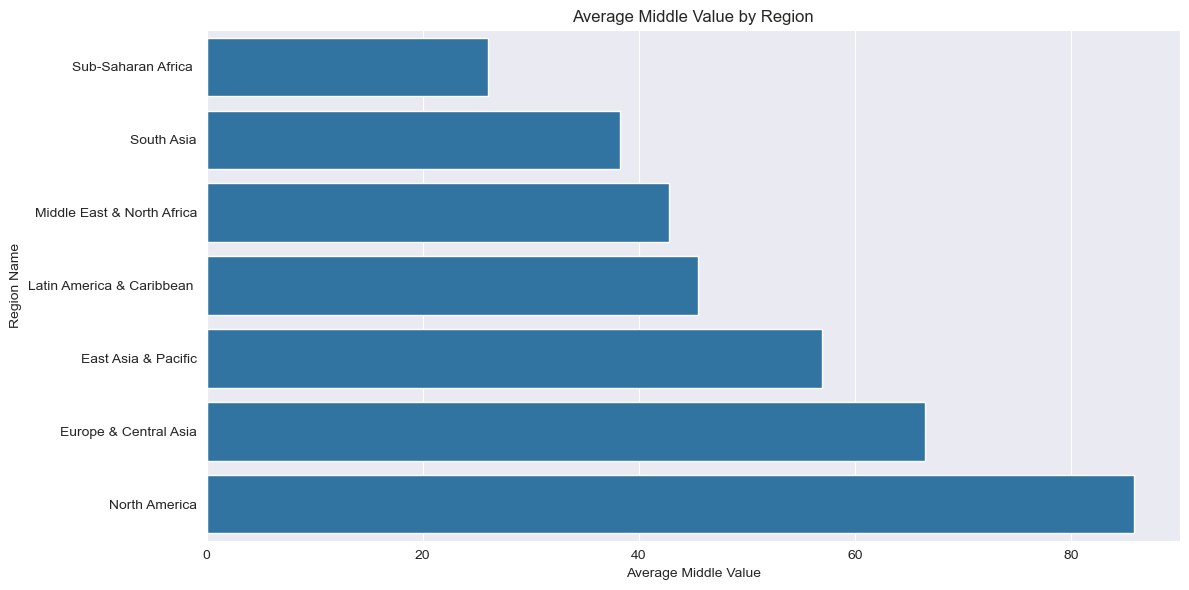

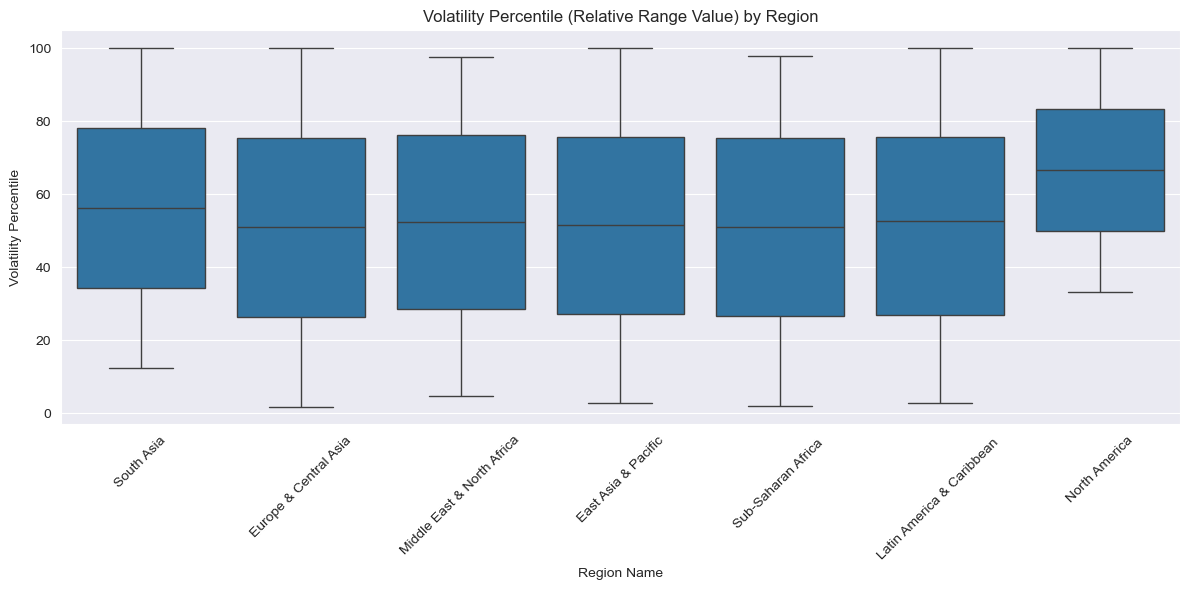

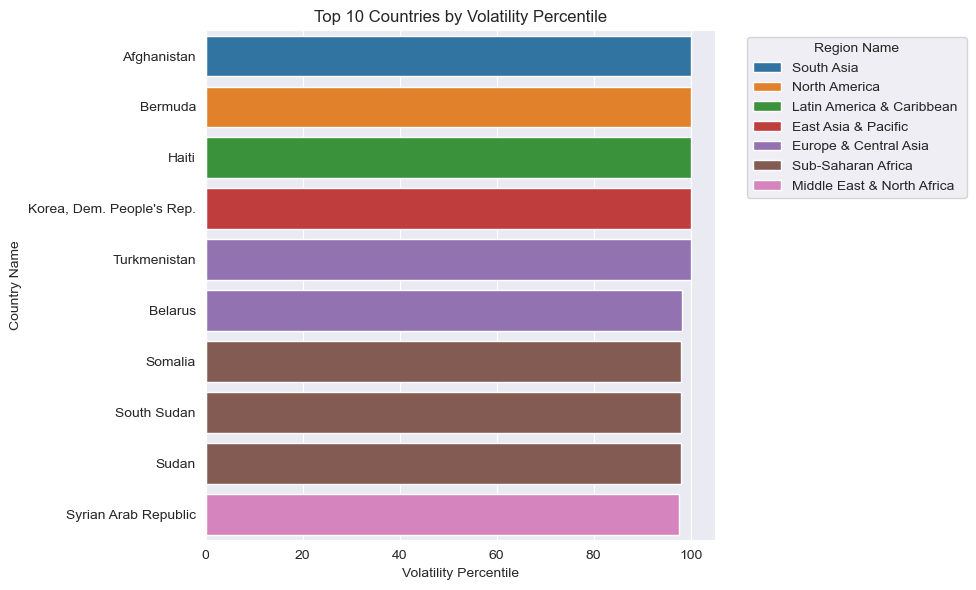

In [48]:
# Keep only the most recent date for each country
most_recent_df = full_df.loc[full_df.groupby('Country/Region')['Date'].idxmax()]

# Merge with country data
merged_df = pd.merge(combined_df, country_df, left_on='Country/Region', right_on='Country Name')

# Display the final dataframe
merged_df.reset_index(drop=True, inplace=True)

# Calculate percentiles for Relative Range Value within each region
merged_df['Volatility Percentile'] = merged_df.groupby('Region Name')['Relative Range Value'] \
                                         .rank(pct=True) * 100

# Group data by region for average middle value
region_middle_value = merged_df.groupby('Region Name')['Middle Value'].mean().sort_values()

# Distribution of Middle Value by Region
plt.figure(figsize=(12, 6))
sns.barplot(y=region_middle_value.index, x=region_middle_value.values)
plt.title('Average Middle Value by Region')
plt.xlabel('Average Middle Value')
plt.ylabel('Region Name')
plt.tight_layout()
plt.show()

# Distribution of Volatility Percentile across Regions
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='Region Name', y='Volatility Percentile')
plt.xticks(rotation=45)
plt.title('Volatility Percentile (Relative Range Value) by Region')
plt.xlabel('Region Name')
plt.ylabel('Volatility Percentile')
plt.tight_layout()
plt.show()

# Highlighting Top Volatile Regions
top_volatility = merged_df.nlargest(10, 'Volatility Percentile')[['Country Name', 'Region Name', 'Volatility Percentile', 'Middle Value']]
plt.figure(figsize=(10, 6))
sns.barplot(data=top_volatility, y='Country Name', x='Volatility Percentile', hue='Region Name', dodge=False)
plt.title('Top 10 Countries by Volatility Percentile')
plt.xlabel('Volatility Percentile')
plt.ylabel('Country Name')
plt.legend(title='Region Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



### Political Stability and Absence of Violence/Terrorism

In [22]:
specific_topics=topics_df[topics_df['id'].isin(['PV.PER.RNK.LOWER','PV.PER.RNK.UPPER'])]
print(f"Description:\n\t{specific_topics['sourceNote'].iloc[0]}\n\nSource Organization:\n\t{specific_topics['sourceOrganization'].iloc[0]}")

Description:
	Political Stability and Absence of Violence/Terrorism measures perceptions of the likelihood of political instability and/or politically-motivated violence, including terrorism.  Percentile rank indicates the country's rank among all countries covered by the aggregate indicator, with 0 corresponding to lowest rank, and 100 to highest rank.  Percentile ranks have been adjusted to correct for changes over time in the composition of the countries covered by the WGI.  Percentile Rank Lower refers to lower bound of 90 percent confidence interval for governance, expressed in percentile rank terms.

Source Organization:
	Detailed documentation of the WGI, interactive tools for exploring the data, and full access to the underlying source data available at www.govindicators.org. The WGI are produced by Daniel Kaufmann (Natural Resource Governance Institute and Brookings Institution) and Aart Kraay (World Bank Development Research Group).  Please cite Kaufmann, Daniel, Aart Kraay a

### Rule of Law

In [24]:
specific_topics=topics_df[topics_df['id'].isin(['RL.PER.RNK.LOWER','RL.PER.RNK.UPPER'])]
print(f"Description:\n\t{specific_topics['sourceNote'].iloc[0]}\n\nSource Organization:\n\t{specific_topics['sourceOrganization'].iloc[0]}")

Description:
	Rule of Law captures perceptions of the extent to which agents have confidence in and abide by the rules of society, and in particular the quality of contract enforcement, property rights, the police, and the courts, as well as the likelihood of crime and violence. Percentile rank indicates the country's rank among all countries covered by the aggregate indicator, with 0 corresponding to lowest rank, and 100 to highest rank.  Percentile ranks have been adjusted to correct for changes over time in the composition of the countries covered by the WGI.  Percentile Rank Lower refers to lower bound of 90 percent confidence interval for governance, expressed in percentile rank terms.

Source Organization:
	Detailed documentation of the WGI, interactive tools for exploring the data, and full access to the underlying source data available at www.govindicators.org. The WGI are produced by Daniel Kaufmann (Natural Resource Governance Institute and Brookings Institution) and Aart Kra

### Regulatory Quality

In [23]:
specific_topics=topics_df[topics_df['id'].isin(['RQ.PER.RNK.LOWER','RQ.PER.RNK.UPPER'])]
print(f"Description:\n\t{specific_topics['sourceNote'].iloc[0]}\n\nSource Organization:\n\t{specific_topics['sourceOrganization'].iloc[0]}")

Description:
	Regulatory Quality captures perceptions of the ability of the government to formulate and implement sound policies and regulations that permit and promote private sector development. Percentile rank indicates the country's rank among all countries covered by the aggregate indicator, with 0 corresponding to lowest rank, and 100 to highest rank.  Percentile ranks have been adjusted to correct for changes over time in the composition of the countries covered by the WGI.  Percentile Rank Lower refers to lower bound of 90 percent confidence interval for governance, expressed in percentile rank terms.

Source Organization:
	Detailed documentation of the WGI, interactive tools for exploring the data, and full access to the underlying source data available at www.govindicators.org. The WGI are produced by Daniel Kaufmann (Natural Resource Governance Institute and Brookings Institution) and Aart Kraay (World Bank Development Research Group).  Please cite Kaufmann, Daniel, Aart Kra

## Case Study: United States